# STAT201 Group Project Report
# Parent's Educational Attainment and Children's Intellectual Development

*Jack Yao, Jessie Lu, Kexin Feng, Vincent Luong*

### Sections
- #### [Introduction](#intro)
- #### [Preliminary Analysis](#prelim)
- #### [Further Analysis and Results](#further)
    - ##### [Bootstrap-based approach](#boot)
    - ##### [Theory-based approach](#theory)
- #### [Discussion](#discuss)
- #### [References](#refer)


# Introduction <a id = 'intro'>
Student Performance is a general term used to describe how well a student has mastered what is taught in school. In our experiment, we will use students' grades to quantify student performance and ultimately intellect. Although countless factors contribute to a student's academic performance, for simplicity we will assume performance on mathematics is representative of the student's performance; a study published in 2019 [(Mammarella et al., 2019)](#ref_2) explores the impact of parents' attitudes and behaviors towards math on their child's mathematic performance. There was evidence that parents majoring in elementary education tend to have higher math anxiety than those attending college. Another study [(Muhammad et al., 2020)](#ref_3) also suggests that the high education of father and mother positively contributes to their children's academic achievement. Our research is inspired by these findings, aiming to investigate the relationship between parental education and the child's mathematic performance.

The dataset [(2014)](#ref_1) that will be used in this project is the Student Performance on Math dataset from the UCI machine learning repository. This project will conduct a hypothesis test to determine whether the difference between the mean (mathematic) student performance of "well-educated" and "less-educated" parents is statistically significant. The classification of parents’ level of education is determined in the preliminary analysis. The measured student performance is reflected in grades on a numeric scale from $0$ to $20$. 

### Research Question:
Is the mean (mathematic) student performance of those with well-educated parents greater than that of those with less-education parents?

$H_0: \mu_1 - \mu_2 = 0$

$H_a: \mu_1 - \mu_2 > 0$

$\mu_1$: Mean student performance of well-educated parents’ group.

$\mu_2$: tudent performance of less-educated parents’ group. 

The hypothesis test will be conducted at a significance level of $\alpha = 1\%$.

# Preliminary Analysis <a id = 'prelim'>
This section will involve:
- Reading data from UCI database
- Wrangling, analyzing, and plotting relevant data
    - [Classifying parents' education](#parents)
    - [Wrangling student's grades](#students)
- Computing point estimates

In [140]:
# load libraries and set seed
set.seed(8888)
library(tidyverse)
library(tidymodels)
library(infer)

### Reading and Cleaning Data from Database

In [141]:
# Reading data from UCI Machine Learning Repository and extract CSV file from zip file
url <- "https://archive.ics.uci.edu/static/public/320/student+performance.zip"
download.file(url, "./data/studentperformance.zip")
raw_data <- unzip("./data/studentperformance.zip", "student.zip", exdir = "./data") |>
    unzip("student-mat.csv", exdir = "./data") |>
    read_delim(delim = ";")

# Refactoring column names
student_data <- raw_data |>
    select(Medu, Fedu, G1, G2, G3)
colnames(student_data) <- c("mother_education", "father_education", "term_1_grade", "term_2_grade", "final_grade")

cat("[Table 1] Unwrangled student data with relevant variables")
head(student_data)

Rows: 395 Columns: 33
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (17): school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardi...
dbl (16): age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[Table 1] Unwrangled student data with relevant variables

mother_education,father_education,term_1_grade,term_2_grade,final_grade
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,4,5,6,6
1,1,5,5,6
1,1,7,8,10
4,2,15,14,15
3,3,6,10,10
4,3,15,15,15


### Wrangling, Analyzing, and Plotting Data

#### Classifying parents' education <a id='parents'></a>

Seen from documentation of the dataset [(2014)](#ref_1), the mother's and father's education levels are as follows:

[Table 2] Education Level Explanation
|Score|Education level|
|-|-|
|$0$|None|
|$1$|up to 4th grade|
|$2$|5th to 9th grade|
|$3$|Secondary education|
|$4$|Postsecondary education|


Below are plots of the distribution of the parents' education scores by assuming the score as numeric rather than categorical:

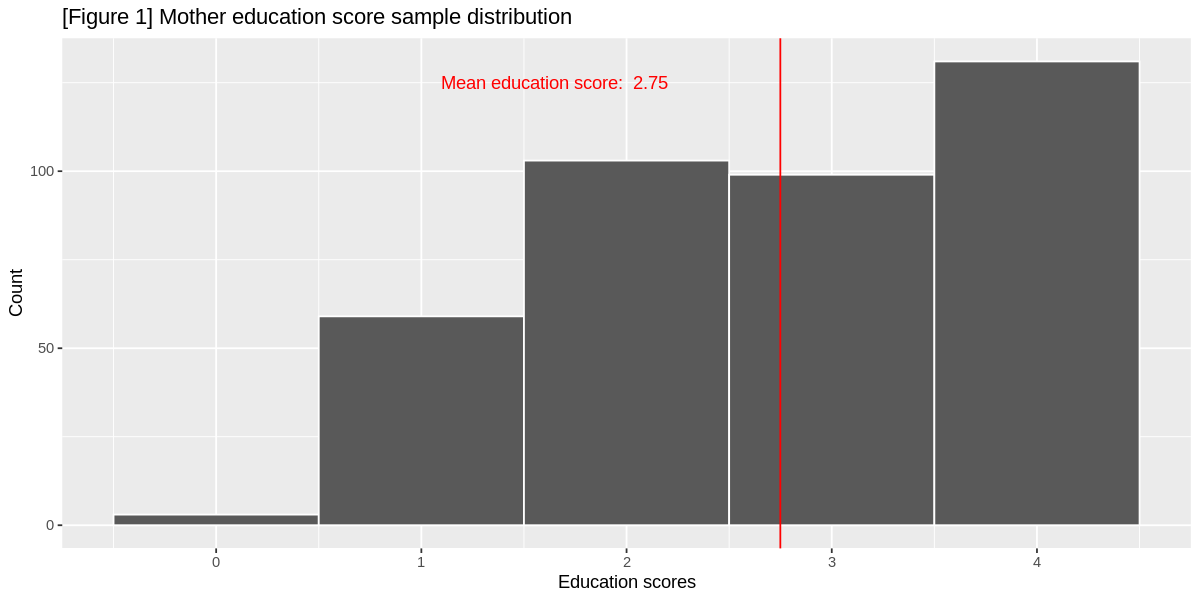

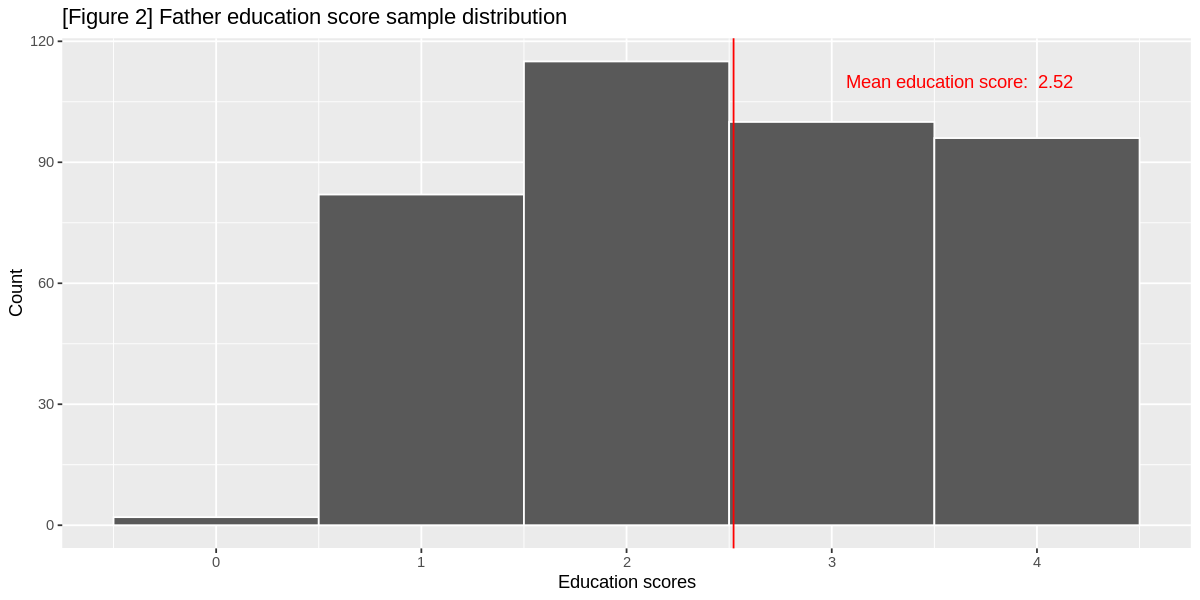

In [142]:
options(repr.plot.width = 10, repr.plot.height = 5)

# Plot education scores of mothers
mother_education_plot <- student_data |>
    ggplot(aes(x = mother_education)) +
    geom_histogram(binwidth = 1, color = 'white') +
    geom_vline(aes(xintercept = mean(mother_education)), color = 'red') +
    annotate("text", label = paste("Mean education score: ", round(mean(student_data$mother_education), digits = 2)), 
             x = mean(student_data$mother_education) - 1.1, y = 125, color = 'red') +
    ggtitle("[Figure 1] Mother education score sample distribution") +
    xlab("Education scores") +
    ylab("Count") +
    labs()

# Plot educations scores of fathers
father_education_plot <- student_data |>
    ggplot(aes(x = father_education)) +
    geom_histogram(binwidth = 1, color = 'white') +
    geom_vline(aes(xintercept = mean(father_education)), color = 'red') +
    annotate("text", label = paste("Mean education score: ", round(mean(student_data$father_education), digits = 2)), 
             x = mean(student_data$father_education) + 1.1, y = 110, color = 'red') +
    ggtitle("[Figure 2] Father education score sample distribution") +
    xlab("Education scores") +
    ylab("Count")

mother_education_plot
father_education_plot

From the plots above, figure $1$ and $2$, it can be observed that they differ slightly in the shape, but otherwise share similar characteristics; there are very little observations of parents with "no education level" and most of the observations tend towards the upper end of the scale with both centers being about $2$ to $3$.

With consideration of the fact that they share similar centers, the education scores of the respective parents are summed under the assumption that the individual parent education scores along with the sex of the parent are not respectively significant (e.g. father and mother with score of $5$ and $5$ vs. $1$ and $9$ vs. $9$ and $1$ are equivalent). Under this assumption, the process of classifying "well-educated" and "less-educated" parents is simplified and more generalized without further research beyond the scope of statistics.

Below is the distribution of the combined parents education scores:

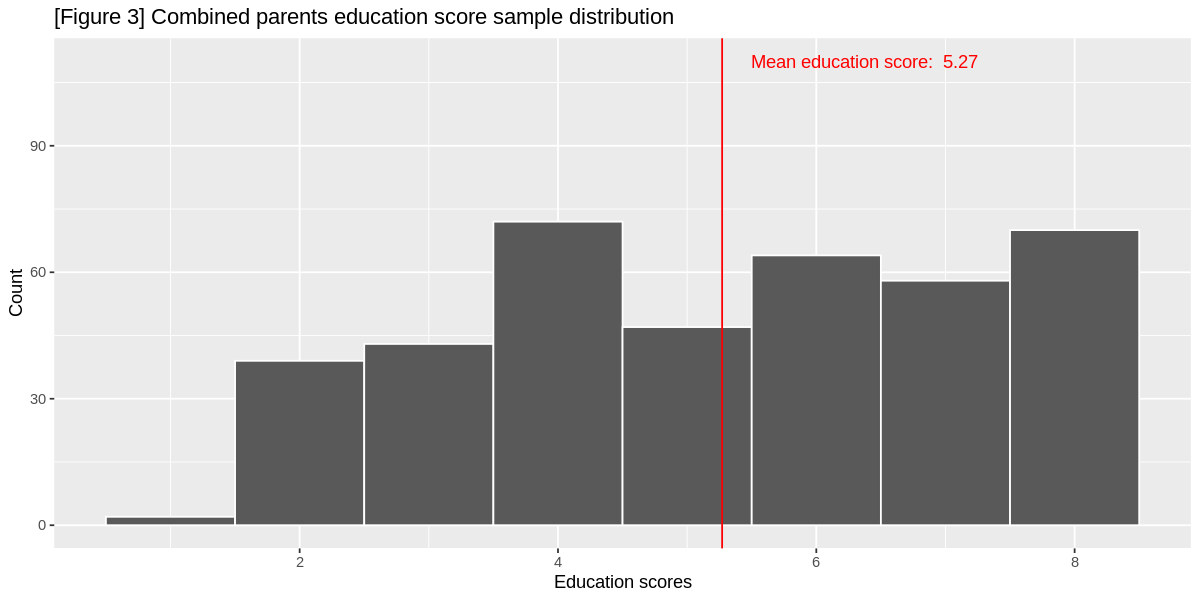

In [144]:
# Combine parents education scores
student_data_combined_edu <- student_data |>
    mutate(combined_education = father_education + mother_education)

# Plot combined education scores
combined_education_plot <- student_data_combined_edu |>
    ggplot(aes(x = combined_education)) +
    geom_histogram(binwidth = 1, color = 'white') +
    geom_vline(aes(xintercept = mean(combined_education)), color = 'red') +
    annotate("text", label = paste("Mean education score: ", round(mean(student_data_combined_edu$combined_education), digits = 2)), 
             x = mean(student_data_combined_edu$combined_education) + 1.1, y = 110, color = 'red') +
    ggtitle("[Figure 3] Combined parents education score sample distribution") +
    xlab("Education scores") +
    ylab("Count")

combined_education_plot

Without additional context from the data, it is unreasonable to assume any educational standards, e.g. "high school should be the minimum education". Therefore, to avoid further assumptions about the educational standards of this data's origin, the description representing each score will be disregarded and the scores will be solely treated as numeric values. As such, the parents' education would then be classified by splitting at the median to obtain a roughly equal split. Although the median may not be the only way to split and classify, it avoids most assumptions about the extent of "well-educated" and is a more generalizable approach.

In [145]:
# Find median value
split <- quantile(student_data_combined_edu$combined_education, 0.5)

# Split and classify
student_data_classified_edu <- student_data_combined_edu |>
    mutate(parents_education = ifelse(combined_education <= split, "less", "well")) |>
    select(term_1_grade, term_2_grade, final_grade, parents_education)

# Overview of split groups
cat("[Table 3] Count for Each Group")
student_data_classified_edu |>
    group_by(parents_education) |>
    summarize(n = n())

[Table 3] Count for Each Group

parents_education,n
<chr>,<int>
less,203
well,192


#### Wrangling student's grades <a id='students'></a>

Referring again to the documentation [(1)](#ref_1), all three of a student's grades are integers in the interval $[0, 20]$.

Below are plots of the distribution of students' first, second, and final grades grouped by the parents' education classification found above:

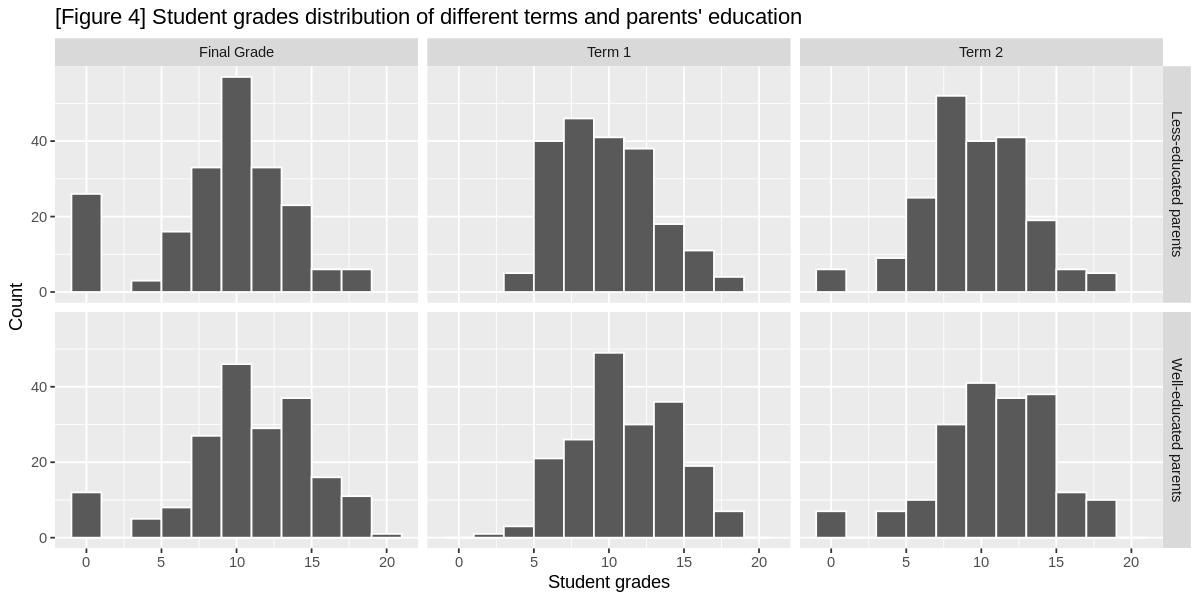

In [146]:
options(repr.plot.width = 10, repr.plot.height = 5)

# Labels for facet_grid
labels <- c(`term_1_grade` = "Term 1", `term_2_grade` = "Term 2", `final_grade` = "Final Grade",
           `less` = "Less-educated parents", `well` = "Well-educated parents")

# Plot all grades along with parents' education
student_grade_plots <- student_data_classified_edu |>
    pivot_longer(names_to = "term", values_to = "grade", cols = c(term_1_grade, term_2_grade, final_grade)) |>
    ggplot(aes(x = grade)) +
    facet_grid(rows = vars(parents_education), cols = vars(term), labeller = as_labeller(labels)) +
    geom_histogram(binwidth = 2, color = 'white') +
    ggtitle("[Figure 4] Student grades distribution of different terms and parents' education") +
    xlab("Student grades") +
    ylab("Count")

student_grade_plots

Seen from the figure $4$ above, it seems that most of the distributions seem somewhat normal with center around $10$. However, looking at `Final Grade` and `Term 2` for both groups of parents, there appears to be an increasing frequency for grades of $0$. Below is an overview of those with a final grade of $0$:

In [112]:
# Observe students with a final grade of 0
cat("[Table 4] Zero Final Grade Overview")
student_data_classified_edu |>
    filter(final_grade == 0) |>
    mutate(average_term_grades = (term_1_grade + term_2_grade)/2) |>
    select(term_1_grade, term_2_grade, final_grade) |>
    head(10)

[Table 4] Zero Final Grade Overview

term_1_grade,term_2_grade,final_grade
<dbl>,<dbl>,<dbl>
7,4,0
12,0,0
8,0,0
9,0,0
11,0,0
10,0,0
4,0,0
7,9,0
5,0,0


Observing the overview, it can be seen from a general glance that those with a final grade of $0$ tend to also have "relatively poorer" grades in the preceding two terms. As the significance of $0$ wasn't documented in the original data, it's difficult to determine whether it represents missing/null data or other holistic factor such as failing by not reaching a certain cutoff. Due to this uncertainty, the mean of all three grades will be used to represents the student's grade to mitigate severe skewness. Below are the distributions of the final grades and the average grades of students with respect to parents' education:

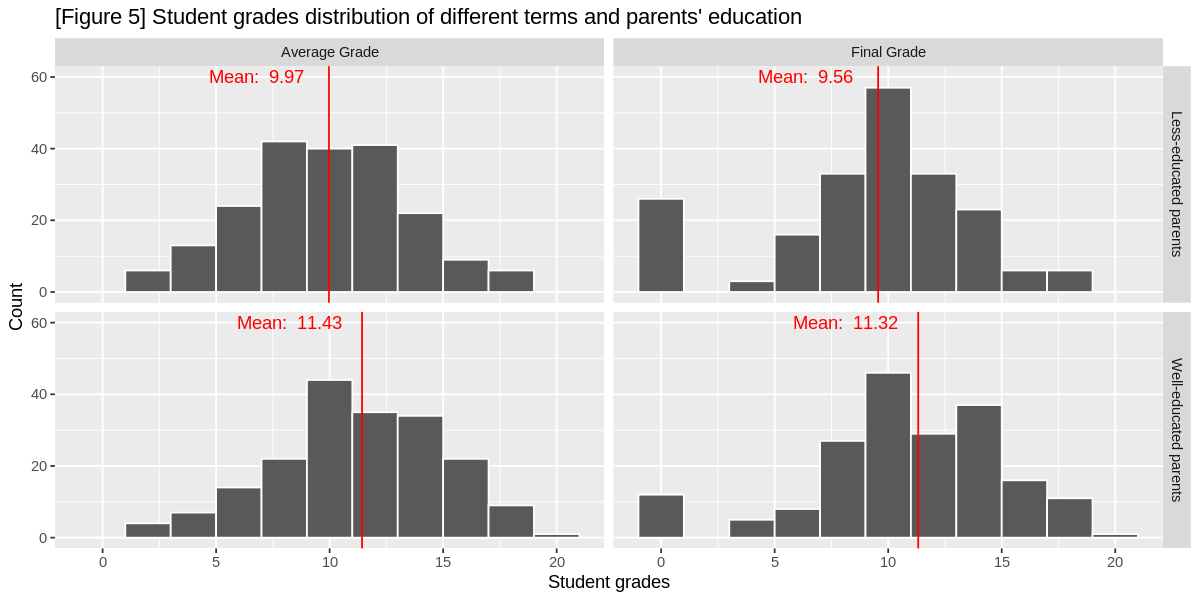

In [147]:
# Find average grades
student_data_average <- student_data_classified_edu |>
    mutate(average_grade = (term_1_grade + term_2_grade + final_grade) / 3)

# Labels for facet_grid
labels2 <- c(`average_grade` = "Average Grade", `final_grade` = "Final Grade",
           `less` = "Less-educated parents", `well` = "Well-educated parents")

# Find averages for respective distributions
averages <- student_data_average |>
    group_by(parents_education) |>
    summarize(final_grade = mean(final_grade), average_grade = mean(average_grade)) |>
    pivot_longer(names_to = "type", values_to = "grade", cols = c(final_grade, average_grade)) |>
    mutate(lab = paste("Mean: ", round(grade, digits = 2)), x = grade - 3.2, y = 60)

# Plot final grades only vs. average grades
student_final_vs_average_grades_plot <- student_data_average |>
    pivot_longer(names_to = "type", values_to = "grade", cols = c(final_grade, average_grade)) |>
    ggplot(aes(x = grade)) +
    facet_grid(rows = vars(parents_education), cols = vars(type), labeller = as_labeller(labels2)) +
    geom_histogram(binwidth = 2, color = 'white') +
    geom_vline(data = averages, aes(xintercept = grade), color = "red") +
    geom_text(data = averages, color = "red", aes(x = x, y = y, label = lab)) +
    ggtitle("[Figure 5] Student grades distribution of different terms and parents' education") +
    xlab("Student grades") +
    ylab("Count")

student_final_vs_average_grades_plot

Comparing the distribtions seen in figure $5$, the centers with respect to the parents' education seems to be similar while the average grade does not appear to have any outliers. In addition, the spread of the distributions appear similar. Due to the absence of outliers (i.e. the $0$ seen in final grade), it is reasonable to continue the analysis by using the average grade to avoid further assumptions.

**Note**: when referring to the documentations [(1)](#ref_1), it should be mentioned that the students have been sampled from two different schools, which may give rise to bias from different schooling environments. However, our goal is to test parental education levels, so it is assumed that this confounding variable is trivial.

# Further Analysis and Results <a id='further'>

### Hypothesis Test

As previously stated in the [introduction](#intro), our hypothesis test are as follows:

Null hypothesis $H_0: \mu_1 - \mu_2 = 0$

Alternative hypothesis $H_a: \mu_1 - \mu_2 > 0$

$\mu_1$: Mean student (mathematic) performance of well-educated parents’ group.

$\mu_2$: Mean student (mathematic) performance of less-educated parents’ group. 

Significance level $\alpha = 1\%$ or $0.01$.

This hypothesis test will be tested with two approaches: [bootstrap-based](#boot) and [asymptotic](#theory). By conducting the same hypothesis test through different methods, obtaining consistent results from both indicates that the results are likely reliable in terms of code and testing process.

### Bootstrap-based Hypothesis Test <a id = 'boot'>

The assumptions to conducting a bootstrap-based hypothesis test is are as follows:
- The sample(s) are representative of the population(s).
- The sample(s) are large enough to produce a reliable bootstrap distribution.
    
Below is the hypothesis test conducted with a bootstrap-based approach:

P-Value for bootstrap-based hypothesis test:  0.0005

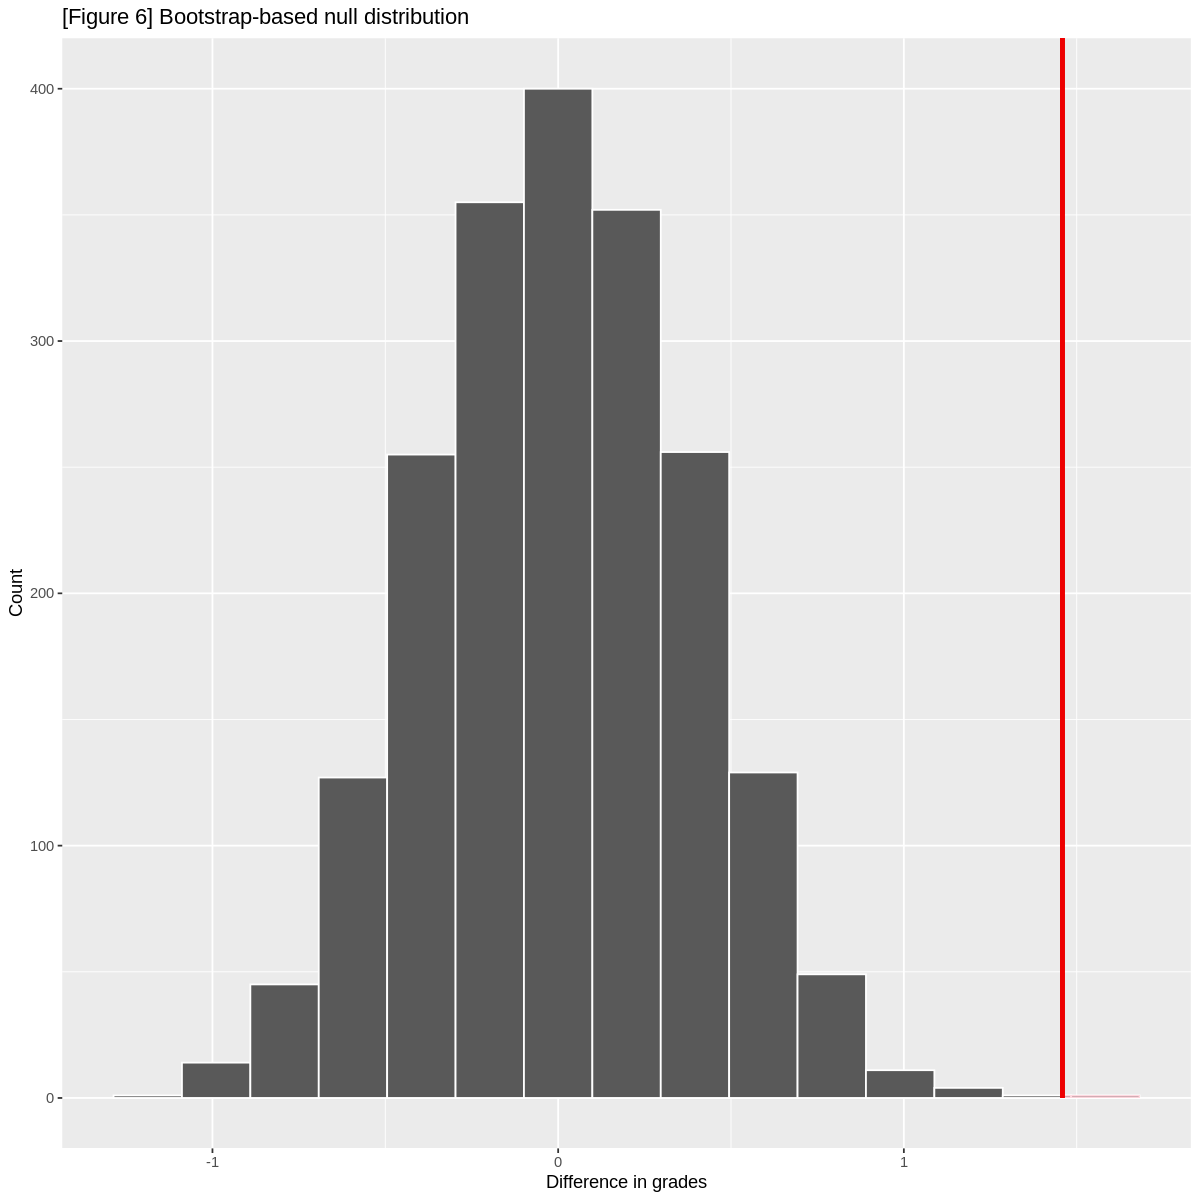

In [148]:
# Increase height for better visualization
options(repr.plot.width = 10, repr.plot.height = 10, scipen = 2)

student_data_final <- student_data_average |>
    select(average_grade, parents_education)

# Calculate observed test statistic
obs_stat <- student_data_final |>
    specify(average_grade ~ parents_education) |>
    calculate(stat = "diff in means", order = c("well", "less"))

# Generate null model
null_model_boot <- specify(student_data_final, formula = average_grade ~ parents_education) |>
    hypothesize(null = "independence") |>
    generate(type = "permute", reps = 2000) |>
    calculate(stat = "diff in means", order = c("well", "less"))

# Visualize
null_model_boot |> visualize() + 
    shade_p_value(obs_stat, direction = "greater", size = 1) +
    ggtitle("[Figure 6] Bootstrap-based null distribution") +
    xlab("Difference in grades") +
    ylab("Count")

# Output p-value
cat(paste("P-Value for bootstrap-based hypothesis test: ", get_p_value(null_model_boot, obs_stat, direction = "greater")))

Given that the p-value ($0.0005$) is less than our set significance level, there is sufficient evidence to reject the null hypothesis $H_0$. The obtained p-value from the bootstrap-based hypothesis test indicates there is a statistically significant difference between the mathematical performance of students with "well-educated" parents and that of those with less-educated parents. 

### Asymptotic Theory-based Hypothesis Test <a id = 'theory'>

In order to conduct the hypothesis test via asymptotic theory, the following assumptions are made (central limit theorem):
- The sample(s) are randomly obtained.
- The sample size(s) are independent (less than $10\%$ of the population size(s))
- The population distribution for the average grades is normal *or* the sample size is large enough for the parents' education groups respectively.

Additionally, since the population standard deviation is unknown, the null model will be t-distribution with the calculated degree of freedom for two samples, and the p-value is calculated with that null model. Alternatively, the test for theory-based approach is called `two-sample t-test`.
    
Below is the hypothesis test conducted with an asymptotic-based approach:

[Table 5] Test statistics for less-educated group

n,mean,sd
<int>,<dbl>,<dbl>
203,9.97044,3.54434


[Table 6] Test statistics for well-educated group

n,mean,sd
<int>,<dbl>,<dbl>
192,11.4288,3.7157


P-Value for theory-based hypothesis test:  0.0000399537

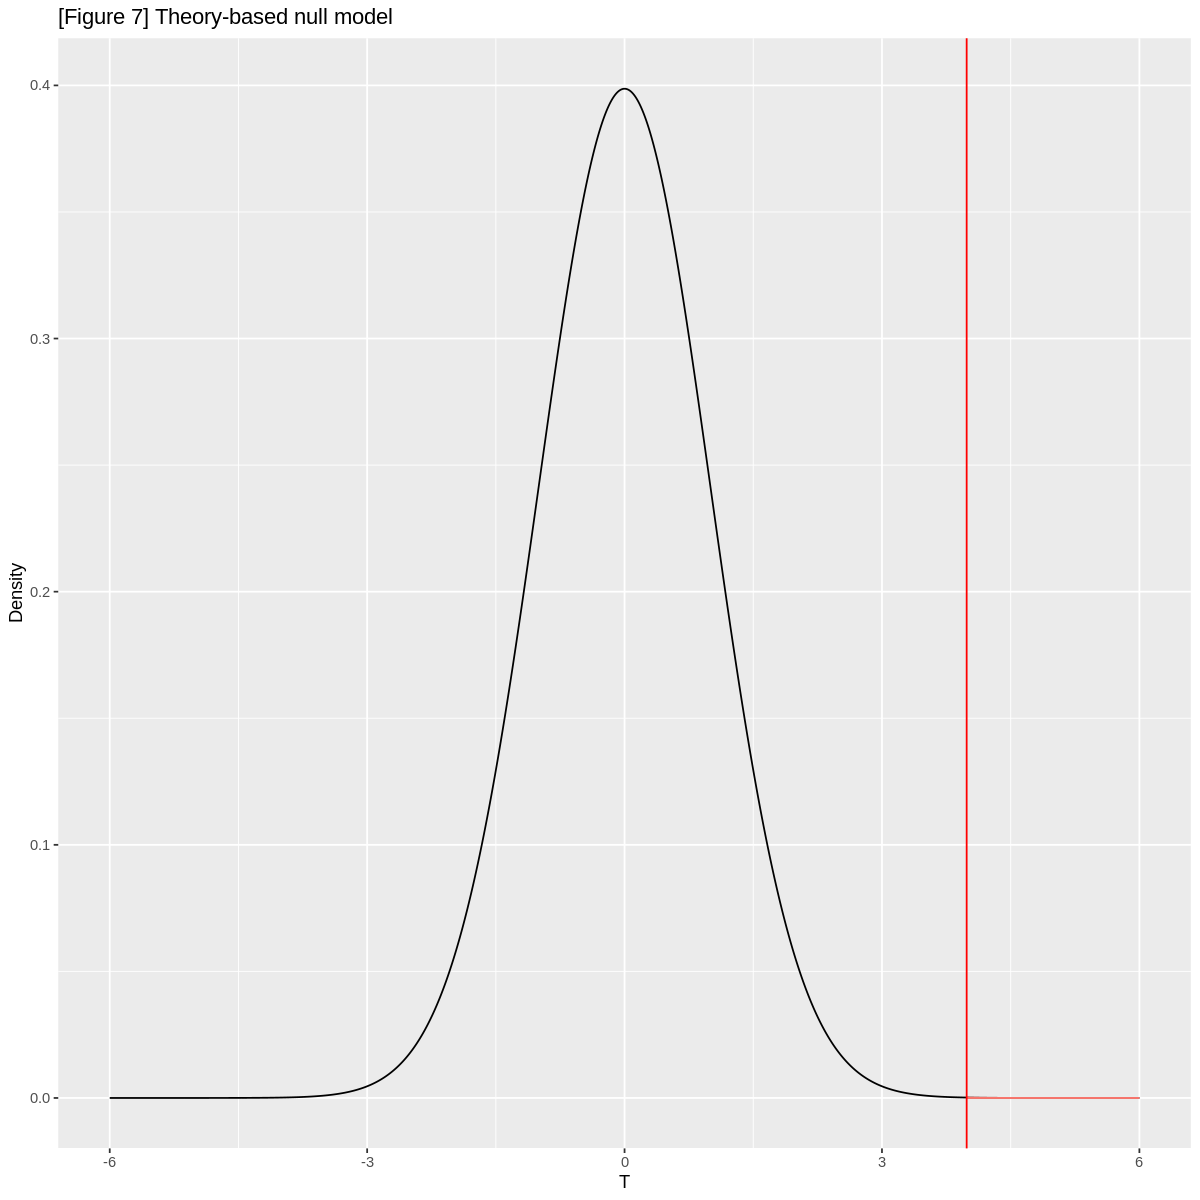

In [151]:
# Find statistics of student grades of "less-educated" and "well-educated" parents
less_stat <- student_data_final |>
    filter(parents_education == "less") |>
    summarize(n = n(), mean = mean(average_grade), sd = sd(average_grade))

well_stat <- student_data_final |>
    filter(parents_education == "well") |>
    summarize(n = n(), mean = mean(average_grade), sd = sd(average_grade))

cat("[Table 5] Test statistics for less-educated group")
less_stat
cat("[Table 6] Test statistics for well-educated group")
well_stat

# Calculate the degree of freedom for null model
df <- (less_stat$sd^2 / less_stat$n + well_stat$sd^2 / well_stat$n)^2 / (less_stat$sd^4 / (less_stat$n^2 * (less_stat$n - 1)) + well_stat$sd^4 / (well_stat$n^2 * (well_stat$n - 1)))

plot_range <- tibble(lower = -6, upper = 6)

# Generate null model
null_model_theory <- tibble(t = seq(from = plot_range$lower, to = plot_range$upper, by = 0.01), density = dt(t, df))

# Calculate test statistic
test_stat <- (well_stat$mean - less_stat$mean)/sqrt(well_stat$sd^2/well_stat$n + less_stat$sd^2/less_stat$n)

# Plot null model
ggplot(null_model_theory) + 
    geom_line(aes(x = t, y = density)) + 
    geom_ribbon(data = subset(null_model_theory, t > test_stat & t < plot_range$upper), mapping = aes(x = t, ymax = density, fill = "red", color = "red"), ymin = 0, alpha = 0.3) +
    geom_vline(aes(xintercept = test_stat), color = 'red') +
    theme(legend.position="none") +
    ggtitle("[Figure 7] Theory-based null model") +
    xlab("T") +
    ylab("Density")
    

# Output p-value
cat(paste("P-Value for theory-based hypothesis test: "), pull(tibble(p_value = pt(test_stat, df, lower.tail = F))))

Likewise, the p-value ($\approx0.00004$) is less than the significance level, indicating there is sufficient evidence to reject the null hypothesis $H_0$. This result obtained through theory-based approach is consistent with the results obtained through the bootstrap-based approach under the same significance level and data. Therefore, it is reasonable to conclude that the actual mean (mathematic) performance of students with "well-educated" parents is not equal to that of students with "less-educated" parents.

#### Comparison between bootstrapping and asymptotic theory for hypothesis testing

Despite the consistent conclusion from both approaches (rejecting the null hypothesis), the numerical results (p-value) aren't the same. The variability of the p-value can be attributed to the overall sampling randomness from performing these methods; bootstrapping involves random samples and thus variation in the mean differences, whereas asymptotic theory provides an estimation of the sampling distribution with uncertainty in the truth of the assumptions made (central limit theorem). 

This variation in p-value in this analysis is trivial in comparison to the significance level, however, it brings attention to the reliability of the approaches. Through many adjustments, the bootstrapping method often yielded a p-value of $0$ due to a lack of bootstrapped measurements near such an extreme test statistic to generate any "area". In spite of the frequent null p-values, bootstrapping can be considered more "trustworthy" in this analysis, as the lack of information regarding the origin of the whole data can create doubt about the assumptions made for the asymptotic theory. Conversely, the asymptotic theory is more "numerically reliable", as it is mathematically impossible to yield a flat p-value of $0$.

# Discussion <a id='discuss'>

    
### Expectations/Impacts/Future Questions.
 
 Through statistical analysis and inference, we expect to find if there exists sufficient evidence to prove/disprove whether the parent's (combined) education level plays a critical role in a student's performance in mathematics, which will lead to a better understanding in the social dynamic of a family.  The importance of parental education and its effect on a child's intellectual development for other subjects will be questioned.  Questions of should more/less parent's be seeking higher education and what will better help a child's intellectual development will arise.
    
duiscussion here
    
    notes for possible discussion after we go over with ta
    - bootstrap results
    - asymptotic-based results
    - compare our intial predictions with our end results
    - type I error and talk about how to minimize it 
    - discuss whether there were any variables that werent accounted for (e.g. parental salary for more supplies, parental intervention/involment in children's math practices. Refer to article:https://files.eric.ed.gov/fulltext/EJ1227483.pdf )

#### Discuss future quetsions/research:
 - Subject Variation: The impact of parents' educational level on student performance may vary across different academic subjects. While our initial study just focus on math performance, it's important to consider whether the relationship between parents' educational level and academic achievement holds true for other subjects as well. For example,  we can compare the relationship between parents' educational level and student performance in math to other subjects, such as language arts, science, or social studies. And, trying to find if there are differences in the strength of the relationship. 
 - Parents’ education strategies: Parents may use different strategies to actively engage with their children's education to promote better academic outcomes. Investigating effective strategies for enhancing student performance based on parents' educational backgrounds can provide valuable insights for educators, students, and parents themselves. For example, did well-educated parents provide more course-related activities? We can study the types activities parents provide, such as puzzles, games, and educational software, and find if the greater student performance is caused by more logically structured family activities.
    
    
 #### Discuss Error:
Given that both of our methods have led us to reject the null hypothesis, there exists a possibility of a Type I error having occurred. To effectively manage this risk, we can consider two strategies. Firstly, we could further lower the significance level, although our current significance level is already set at a relatively stringent 1%. Aternatively, increasing the sample size.  Modifying the significance level would make the result more stringent in the criteria for rejecting the null hypothesis. Alternatively, expanding the sample size holds the advantage of enhancing the statistical power, thereby reducing the likelihood of erroneously rejecting the null hypothesis. 
    
#### Discuss unaccounted varibale (may be considered as limitation?)
The  consideration of unaccounted variables within our analysis is significant. One such variable that our analysis might overlook is the parental involvement in their children’s math practices. As highlighted in the article, parental involvement has been recognized as a crucial factor influencing students’ academic achievement. While our study has explored the link between parents education and children’s math performance, the potential influence of parental intervention is a facet that may not have been fully considered. Inspired by this article, it provides us the insights into various ways of parents can positively impact their children’s math learning experiences such as engaging in math-related activities and on-hand coaching at home.   

# References <a id='refer'>

1. <a id='ref_1'></a> Cortez,Paulo. (2014). Student Performance. UCI Machine Learning Repository. https://doi.org/10.24432/C5TG7T.

2. <a id='ref_2'></a> Herts, J. B., Beilock, S. L., & Levine, S. C. (2019). The role of parents’ and teachers’ math anxiety in Children’s math learning and attitudes. In I. C. Mammarella, S. Caviola & A. Dowker (Eds.), *Mathematics anxiety* (1st ed., pp. 190-210). Routledge. https://doi.org/10.4324/9780429199981-11

3. <a id='ref_3'></a> Dr. Muhammad Idris, Dr. Sajjad Hussain, & Dr. Nasir Ahmad. (2020). Relationship between Parents’ Education and their children’s Academic Achievement. Journal of Arts & Social Sciences , 7(2), 82-92. https://doi.org/10.46662/jass-vol7-iss2-2020(82-92)